In [1]:
import numpy as np
import pybullet as p
import pybullet_data
import matplotlib.pyplot as plt

import time

from utils import *
from casadi import *
import crocoddyl
from costs import *
from ocp_sys import QuadcopterCasadi, ActionDataRobot, ActionModelRobot
from IPython.display import clear_output
from ocp import ILQR_Standard, get_ilqr_from_ddp
from mixture_model import Gaussian
np.set_printoptions(precision=3, suppress=True)
%load_ext autoreload
%autoreload 2

#### Define the robot_sys

In [2]:
from ocp_sys import Bicopter

In [3]:
sys_name = 'bicopter' #the choices: ['quadcopter', 'bicopter', 'pendulum']


T = 150
dt = 0.05
T_short = 30
n_iter_short = 10
robot_sys = Bicopter(dt = dt)

# 1. Plan using iLQR with long horizon

#### Setting cost

In [4]:
x_ref = np.array([3,3,0,0,0,0]) #for bicopter
Q = np.eye(robot_sys.Dx)*0.01
#Q[2:,2:] = 0*Q[2:,2:] 
Qf = np.eye(robot_sys.Dx)*100
#Qf[2:,2:] = 0*Qf[2:,2:] 
R = np.eye(robot_sys.Du)*.1
    
costs = []
for i in range(T):
    cur_ref = x_ref.copy()
    Q_cur = Q.copy()
    runningStateCost = CostModelQuadratic(robot_sys, Q_cur, x_ref = cur_ref)
    runningControlCost = CostModelQuadratic(robot_sys, None, R)
    runningCost = CostModelSum(robot_sys, [runningStateCost, runningControlCost])        
    costs += [runningCost]

#### Setup crocoddyl model
rmodels = []
for i in range(T):
    state = crocoddyl.StateVector(robot_sys.Dx)
    rmodel = ActionModelRobot(state, robot_sys.Du)
    rmodel.init_robot_sys(robot_sys, nr = robot_sys.Dx)
    rmodel.set_cost(costs[i])
    rmodels += [rmodel]

terminalStateCost = CostModelQuadratic(robot_sys,Qf, x_ref = x_ref)
terminalControlCost = CostModelQuadratic(robot_sys, None,R)
terminalCost = CostModelSum(robot_sys, [terminalStateCost, terminalControlCost])

rmodel_T = ActionModelRobot(state, robot_sys.Du)
rmodel_T.init_robot_sys(robot_sys, nr = robot_sys.Dx)
rmodel_T.set_cost(terminalCost)

#### Setup problem & initial guess

In [5]:
#initial state
if sys_name == 'quadcopter':
    x0 = np.array([ 0.,  0., 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.])
    us = np.zeros((T, robot_sys.Du))
elif sys_name == 'bicopter':
    x0 = np.zeros(6)
    u_shift = 9.8*robot_sys.m/2
    us = np.ones((T, robot_sys.Du))*u_shift

robot_sys.set_init_state(x0)
xs = robot_sys.rollout(us)
problem = crocoddyl.ShootingProblem(x0, rmodels, rmodel_T)

#### Solve

In [6]:
ddp = crocoddyl.SolverFDDP(problem)

ddp.th_grad = 1e-6
ddp.th_stop = 1e-6
ddp.setCallbacks([crocoddyl.CallbackVerbose()])

ddp.solve(list(xs[:,:,None]), list(us[:,:,None]), maxiter=1000)

xs_ref, us_ref = np.array(ddp.xs), np.array(ddp.us)

#### Visualize the path by multiple robots

#### Copy the data from ddp to ilqr solutions

In [7]:
ilqr = ILQR_Standard(robot_sys)
ilqr = get_ilqr_from_ddp(ddp,ilqr)

#### Use Least Square to compute the distribution

In [8]:
from scipy.stats import multivariate_normal

In [9]:
n_samples = 200
_ = ilqr.compute_du_LS()
sample_dxs, sample_dus = ilqr.sample_du(n_samples, allow_singular=False)

sample_dxs = np.array(sample_dxs).reshape(n_samples, T+1, -1)

sampling


#### Plot the cross-section distribution

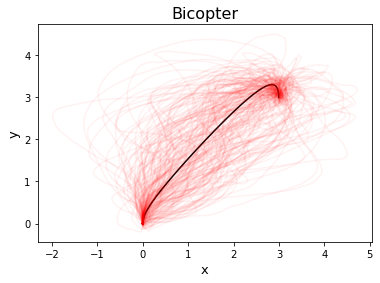

In [10]:
dim = (0,1)
plt.plot(np.array(ddp.xs)[:,dim[0]], np.array(ddp.xs)[:,dim[1]], 'k')
for i in range(n_samples):
    plt.plot(np.array(ddp.xs)[:,dim[0]]+sample_dxs[i,:,dim[0]],np.array(ddp.xs)[:,dim[1]]+sample_dxs[i,:,dim[1]], 'r-', alpha=0.05 )
    #plt.plot(np.array(ddp.xs)[:,0]+sample_dxs[i,:,0],np.array(ddp.xs)[:,1]+sample_dxs[i,:,1], 'r-', alpha=0.05 )
plt.title('Bicopter', fontsize = 16)
plt.xlabel('x', fontsize = 13)
plt.ylabel('y', fontsize = 13)
plt.savefig('temp/bicopter_dist.png', dpi=500)

# 2. Tracking the distribution with various strategies

## Defining the short time horizon ilqr

In [11]:
use_collision = False

In [12]:
#### Setting cost
costs = []
for i in range(T_short+1):
    runningStateCostShort = CostModelQuadratic(robot_sys, Qf, x_ref = x_ref.copy())
    runningControlCostShort = CostModelQuadratic(robot_sys, None, R)
    if use_collision:
        runningCostShort = CostModelSum(robot_sys, [runningStateCostShort, runningControlCostShort, cost_collision])
    else:
        runningCostShort = CostModelSum(robot_sys, [runningStateCostShort, runningControlCostShort])        
    costs += [runningCostShort]

#### Setup crocoddyl model
rmodels = []
for i in range(T_short+1):
    stateShort = crocoddyl.StateVector(robot_sys.Dx)
    rmodelShort = ActionModelRobot(stateShort, robot_sys.Du)
    rmodelShort.init_robot_sys(robot_sys, nr = robot_sys.Dx)
    rmodelShort.set_cost(costs[i])
    rmodels += [rmodelShort]
    
reg_marg = 1e-2
reg_cond = 1e-2

#### Setup problem & initial guess

In [13]:
x0 = xs_ref[0]
robot_sys.set_init_state(x0)
xs = robot_sys.rollout(us)
problemShort = crocoddyl.ShootingProblem(x0, rmodels[:-1], rmodels[-1])
ddpShort = crocoddyl.SolverFDDP(problemShort)

#### Define the noises

In [14]:
noise_amp = 0.5
noise_v = normalize(np.random.rand(3)-0.5)*noise_amp
noise = np.concatenate([np.zeros(3), noise_v])

#set the timing of the noise
noises = np.zeros((T, robot_sys.Dx))
start_t = 30
end_t = 32
for t in range(start_t, end_t):
    noises[t] = noise
print(noise)

[ 0.     0.     0.    -0.318 -0.123 -0.366]


### 2.1. MPC Strategy: following the mean

In [15]:
Qs_mean = np.tile(Qf, (T+T_short+1,1,1))

#initialise x
x = x0.copy()

#set the output containers
xs_mean = [x]
us_mean = []
x_ref_mean_set = [] #ref at each iter
x_output_mean_set = [] #output of ddp at each iter.

#set initial guess
xs_init = xs_ref[:T_short+1]
us_init = us_ref[:T_short]
xs_init[0] = x.copy()

for t in range(T):
    print(t)
    
    #obtain and set the reference traj
    x_ref = subsample(xs_ref[t:t+T_short+1], T_short+1)
    set_ref(ddpShort, x_ref)
    Qs_ref = Qs_mean[t:t+T_short+1]
    set_Qref(ddpShort, Qs_ref)
    #modify the ddp initial point 
    ddpShort.problem.x0 = x
    ddpShort.x0 = x
    
    #solve the ddp
    ddpShort.solve(list(xs_init), list(us_init), n_iter_short)
    clear_output()
    
    #take the first control and execute (with noise)
    u = ddpShort.us[0]
    x = robot_sys.step(x, u) + noises[t]

    #store the data
    xs_mean += [x]
    us_mean += [u]
    x_ref_mean_set += [x_ref]
    x_output_mean_set += [np.array(ddpShort.xs)]
    
    #initialising the next step with the previous solutions
    xs_init = subsample(np.array(ddpShort.xs[1:]), T_short+1)
    us_init = subsample(np.array(ddpShort.us), T_short)
    xs_init[0] = x.copy()

xs_mean = np.array(xs_mean)
us_mean = np.array(us_mean)
cost_mean = ddp.problem.calc(list(xs_mean), list(us_mean))
print('The cost of tracking the mean is {}'.format(cost_mean))

The cost of tracking the mean is 2270.307071559204


### 2.2. MPC Strategy: ILQR Feedback

In [16]:
#initialise x
x = x0.copy()

#setup the output container
xs_res_feed = [x]
us_res_feed = []

for t in range(T):
    print(t)
    u = ddp.us[t] - ddp.K[t].dot(x - ddp.xs[t])
    x = robot_sys.step(x, u) + noises[t]
    xs_res_feed += [x]
    us_res_feed += [u]
    
xs_res_feed = np.array(xs_res_feed)
us_res_feed = np.array(us_res_feed)
cost_feed = ddp.problem.calc(list(xs_res_feed), list(us_res_feed))
clear_output()
print('The cost of ilqr feedback control is is {}'.format(cost_feed))

The cost of ilqr feedback control is is 2272.5292478746187


### 2.3. MPC Strategy: Tracking marginal distribution

#### Compute marginal distribution

In [17]:
_, Qs = extract_ref(xs_ref[1:], ilqr.Sigma_x[robot_sys.Dx:, robot_sys.Dx:], robot_sys.Dx, T+T_short, xs_ref[0], reg_marg)

#### Tracking

In [18]:
#setup the initial state
x = x0.copy()

#setup the output containers
xs_res_dist = [x]
us_res_dist = []
x_ref_dist_set = []
x_output_dist_set = []

#setup the initial guess
xs_init = xs_ref[:T_short+1]
us_init = us_ref[:T_short]
xs_init[0] = x.copy()

for t in range(T):
    print(t)
    
    #extract the reference trajectory dist.
    x_ref = subsample(xs_ref[t:t+T_short+1], T_short+1)
    Qs_ref = Qs[t:t+T_short+1]
    set_ref(ddpShort, x_ref)
    set_Qref(ddpShort, Qs_ref)
    
    #modify the initial state of ddp
    ddpShort.problem.x0 = x
    ddpShort.x0 = x
    
    #solve
    ddpShort.solve(list(xs_init), list(us_init), n_iter_short)
    clear_output()
    
    #take the first control and execute
    u = ddpShort.us[0]
    x = robot_sys.step(x, u) + noises[t]

    #store the output
    xs_res_dist += [x]
    us_res_dist += [u]
    x_ref_dist_set += [x_ref]
    x_output_dist_set += [np.array(ddpShort.xs)]
    
    #set the initial guess from the previous solution
    xs_init = subsample(np.array(ddpShort.xs[1:]), T_short+1)
    us_init = subsample(np.array(ddpShort.us), T_short)
    xs_init[0] = x.copy()

xs_res_dist = np.array(xs_res_dist)
us_res_dist = np.array(us_res_dist)
cost_dist = ddp.problem.calc(list(xs_res_dist), list(us_res_dist))
clear_output()
print('The cost of tracking the marginal distribution is {}'.format(cost_dist))

The cost of tracking the marginal distribution is 2271.3678541162603


### 2.4. MPC Strategy:  tracking conditional distribution

### Setup the trajectory distribution

In [19]:
#the full trajectory distribution
x_dist = Gaussian()
x_dist.D = robot_sys.Dx*(T+1+T_short)
x_dist.mu = ilqr.xs.flatten()
x_dist.sigma = np.zeros((ilqr.Sigma_x.shape[0]+T_short*robot_sys.Dx, ilqr.Sigma_x.shape[1]+T_short*robot_sys.Dx))
x_dist.sigma[:ilqr.Sigma_x.shape[0],:ilqr.Sigma_x.shape[0]] = ilqr.Sigma_x + 1e-6*np.eye(ilqr.Sigma_x.shape[0])
for t in range(T+1, T+1+T_short):
    x_dist.sigma[t*robot_sys.Dx:(t+1)*robot_sys.Dx, t*robot_sys.Dx:(t+1)*robot_sys.Dx] = x_dist.sigma[T*robot_sys.Dx:(T+1)*robot_sys.Dx, T*robot_sys.Dx:(T+1)*robot_sys.Dx]
    x_dist.mu = np.concatenate([x_dist.mu, xs_ref[-1]])
    #the conditional distribution along the time horizon T_short
x_dist_short = Gaussian()
x_dist_short.D = robot_sys.Dx*(T_short+1)

#### Tracking

In [20]:
#set initial state
x = x0.copy()

#set the output container
xs_res_cond = [x]
us_res_cond = []
x_ref_cond_set = []
x_output_cond_set = []

#set the initial guess
xs_init = xs_ref[:T_short+1]
us_init = us_ref[:T_short]
xs_init[0] = x.copy()

Qs_ref_cond_set = []

for t in range(T):
    print(t)
    
    mu,sigma = x_dist.get_marginal(slice(t*robot_sys.Dx, (t+1+T_short)*robot_sys.Dx))
    x_dist_short.mu = mu
    x_dist_short.sigma = sigma

    #get conditional distribution
    mu,sigma = x_dist_short.condition(x, slice(0,robot_sys.Dx), slice(robot_sys.Dx, x_dist.mu.shape[0]))
    x_dist_short.mu = mu
    x_dist_short.sigma = sigma

    #obtain references
    x_ref, Qs_ref = extract_ref(x_dist_short.mu, x_dist_short.sigma, robot_sys.Dx, T_short, x, reg = 1e-2)
    Qs_ref_cond_set.append(Qs_ref)
    
    #set the reference
    set_ref(ddpShort, x_ref)
    set_Qref(ddpShort, 1*Qs_ref)
        
    #modify ddp initial state
    ddpShort.problem.x0 = x
    ddpShort.x0 = x
    
    #solve
    ddpShort.solve(list(xs_init), list(us_init), n_iter_short)
    clear_output()
    
    #take the first control and execute
    u = ddpShort.us[0]
    x = robot_sys.step(x, u) + noises[t]
    
    #store the output into the containers
    xs_res_cond += [x]
    us_res_cond += [u]
    x_ref_cond_set += [x_ref]
    x_output_cond_set += [np.array(ddpShort.xs)]

    #set the initial guess
    xs_init = subsample(np.array(ddpShort.xs[1:]), T_short+1)
    us_init = subsample(np.array(ddpShort.us), T_short)
    xs_init[0] = x.copy()


xs_res_cond = np.array(xs_res_cond)
us_res_cond = np.array(us_res_cond)
Qs_ref_cond_set = np.array(Qs_ref_cond_set)
cost_cond = ddp.problem.calc(list(xs_res_cond), list(us_res_cond))
clear_output()
print('The cost of tracking the conditional distribution is {}'.format(cost_cond))

The cost of tracking the conditional distribution is 2274.178948002382


#### Comparison

In [21]:
print('Feedback: {}, Mean: {}, Dist: {}, Cond: {}'.format(cost_feed, cost_mean, cost_dist, cost_cond))

Feedback: 2272.5292478746187, Mean: 2270.307071559204, Dist: 2271.3678541162603, Cond: 2274.178948002382


#### The reference trajectory

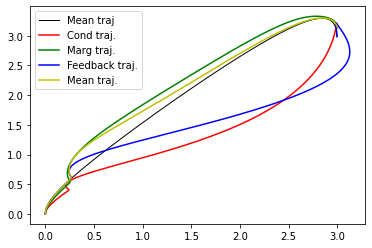

In [51]:
plt.plot(xs_ref[:,dim[0]], xs_ref[:,dim[1]], '-k', label='Mean traj', linewidth=1)
plt.plot(xs_res_cond[:,dim[0]], xs_res_cond[:,dim[1]], 'r', label='Cond traj.')
plt.plot(xs_res_dist[:,dim[0]], xs_res_dist[:,dim[1]], 'g', label='Marg traj.')
plt.plot(xs_res_feed[:,dim[0]], xs_res_feed[:,dim[1]], 'b', label='Feedback traj.')
plt.plot(xs_mean[:,dim[0]], xs_mean[:,dim[1]], 'y', label='Mean traj.')
plt.legend()
plt.show()

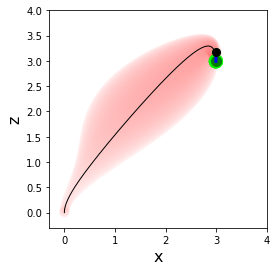

In [83]:
dim = (0,1)
to_save = True
mode = 'cond'
for t in range(len(x_ref_cond_set)):#(start_t, end_t):#
#     if t % 3 != 0: 
#         continue
    print(t)
    fig, ax = plt.subplots()

    #plt.plot(xs_res_cond[:,dim[0]], xs_res_cond[:,dim[1]], 'r', label='Actual traj.')
    
    #Long Reference Trajectory
    plt.plot(xs_ref[:,dim[0]], xs_ref[:,dim[1]], '-k', label='Mean traj', linewidth=1)
    plt.plot(xs_ref[-1,dim[0]], xs_ref[-1,dim[1]], 'og', label='Goal', linewidth=1, markersize=10)  
        
    #Feedback Reference
    if mode == 'feed':
        plt.plot(xs_res_feed[t, dim[0]], xs_res_feed[t, dim[1]], 'ok', label='Current state', markersize=8)
        plt.plot(xs_ref[t+1, dim[0]], xs_ref[t+1, dim[1]], 'ob', label='Current state', markersize=5)
    
    #Mean Reference
    if mode == 'mean':
        x_ref = x_ref_mean_set[t]
        plt.plot(x_ref[:,dim[0]], x_ref[:,dim[1]], '-b', label='Ref. traj (mean)', linewidth=3) 
        for i,x in enumerate(x_ref):
            Q = Qs_mean[i][:2,:2]
            plot_gaussian_2D(x, np.linalg.inv(Q), ax=ax, alpha=0.1, color=(0,1,0))
        plt.plot(xs_mean[t, dim[0]], xs_mean[t, dim[1]], 'ok', label='Current state', markersize=8)
           
    #Conditional reference
    if mode == 'cond':
        for i,x in enumerate(xs_ref):
            Q = Qs[i][:2,:2]
            plot_gaussian_2D(x, np.linalg.inv(Q), ax=ax, alpha=0.01, color=(1,0,0))  
        
        x_ref = x_ref_cond_set[t]
        plt.plot(x_ref[:,dim[0]], x_ref[:,dim[1]], '-b', label='Ref. traj (cond)', linewidth=3) 
        #plt.plot(x_output_cond_set[i][:,dim[0]], x_output_cond_set[i][:,dim[1]], 'k', label='DDP output') 
        Qs_ref_cond = Qs_ref_cond_set[t]
        for i,x in enumerate(x_ref):
            Q = Qs_ref_cond[i][:2,:2]
            plot_gaussian_2D(x, np.linalg.inv(Q), ax=ax, alpha=0.1, color=(0,1,0))
        plt.plot(xs_res_cond[t, dim[0]], xs_res_cond[t, dim[1]], 'ok', label='Current state', markersize=8)
            
        

    #Marginal Reference
    if mode == 'marg':
        for i,x in enumerate(xs_ref):
            Q = Qs[i][:2,:2]
            plot_gaussian_2D(x, np.linalg.inv(Q), ax=ax, alpha=0.01, color=(1,0,0))  

        x_ref = x_ref_dist_set[t]
        plt.plot(x_ref[:,dim[0]], x_ref[:,dim[1]], '-b', label='Ref. traj (marg)', linewidth=3) 
        Qs_ref_marg = Qs[t:t+T_short+1]
        for i,x in enumerate(x_ref):
            Q = Qs_ref_marg[i][:2,:2]
            plot_gaussian_2D(x, np.linalg.inv(Q), ax=ax, alpha=0.1, color=(0,1,0))
        plt.plot(xs_res_dist[t, dim[0]], xs_res_dist[t, dim[1]], 'ok', label='Current state', markersize=8)


    circle = plt.Circle((2,2), radius=0.5)
    #ax.add_artist(circle)
#     plt.legend()
    plt.xlabel('x', fontsize=16)
    plt.ylabel('z', fontsize=16)
    ax.set_aspect('equal')
    ax.set_xlim([-0.3, 4])
    ax.set_ylim([-0.3, 4])
    if to_save:
        plt.savefig('temp/cond_dist_'+str(t)+'.png', dpi=500, bbox_inches='tight')
    clear_output(wait=True)
    plt.show()


In [84]:
if mode == 'mean':
    os.system('ffmpeg -y -r 10  -start_number 0 -i temp/cond_dist_%d.png -c:v libx264 -vf pad="width=ceil(iw/2)*2:height=ceil(ih/2)*2" -r 30 -pix_fmt yuv420p ' + 'temp/mean_traj.mp4')
elif mode == 'marg':
    os.system('ffmpeg -y -r 10  -start_number 0 -i temp/cond_dist_%d.png -c:v libx264 -vf pad="width=ceil(iw/2)*2:height=ceil(ih/2)*2" -r 30 -pix_fmt yuv420p ' + 'temp/marg_traj.mp4')
elif mode == 'cond':
    os.system('ffmpeg -y -r 10  -start_number 0 -i temp/cond_dist_%d.png -c:v libx264 -vf pad="width=ceil(iw/2)*2:height=ceil(ih/2)*2" -r 30 -pix_fmt yuv420p ' + 'temp/cond_traj.mp4')    
elif mode == 'feed':
    os.system('ffmpeg -y -r 10  -start_number 0 -i temp/cond_dist_%d.png -c:v libx264 -vf pad="width=ceil(iw/2)*2:height=ceil(ih/2)*2" -r 30 -pix_fmt yuv420p ' + 'temp/feed_traj.mp4')    

In [85]:
os.system('rm temp/cond_dist_*')

0

#### Plot 1

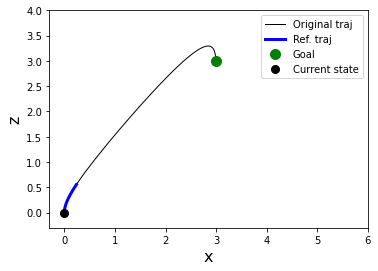

In [98]:
dim = (0,1)
to_save = True
mode = 'marg'
for t in range(1):#len(x_ref_cond_set)):#(start_t, end_t):#
    print(t)
    fig, ax = plt.subplots()

    
    #Long Reference Trajectory
    plt.plot(xs_ref[:,dim[0]], xs_ref[:,dim[1]], '-k', label='Original traj', linewidth=1)
    plt.plot(x_ref[:,dim[0]], x_ref[:,dim[1]], '-b', label='Ref. traj', linewidth=3) 
    plt.plot(xs_ref[-1,dim[0]], xs_ref[-1,dim[1]], 'og', label='Goal', linewidth=1, markersize=10)      
        



    x_ref = x_ref_dist_set[t]
    plt.plot(xs_res_dist[t, dim[0]], xs_res_dist[t, dim[1]], 'ok', label='Current state', markersize=8)


    circle = plt.Circle((2,2), radius=0.5)
    #ax.add_artist(circle)
#     plt.legend()
    plt.xlabel('x', fontsize=16)
    plt.ylabel('z', fontsize=16)
    ax.set_aspect('equal')
    ax.set_xlim([-0.3, 6])
    ax.set_ylim([-0.3, 4])
    plt.legend()
    if to_save:
        plt.savefig('temp/cond_dist_'+str(t)+'.png', dpi=500, bbox_inches='tight')
    clear_output(wait=True)
    plt.show()


In [91]:
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
from matplotlib.patches import Ellipse

def plot_gaussian_2D(mu, sigma,ax=None,color=[0.7,0.7,0.7],alpha=1.0, label=None):
    if ax is None:
        fig,ax = plt.subplots()
    eig_val, eig_vec = np.linalg.eigh(sigma)
    std = np.sqrt(eig_val)*2
    angle = np.arctan2(eig_vec[1,0],eig_vec[0,0])
    ell = Ellipse(xy = (mu[0], mu[1]), width=std[0], height = std[1], angle = np.rad2deg(angle))
    ell.set_facecolor(color)
    ell.set_alpha(alpha)
    if label is not None:
        ell.set_label(label)
    ax.add_patch(ell)
    return